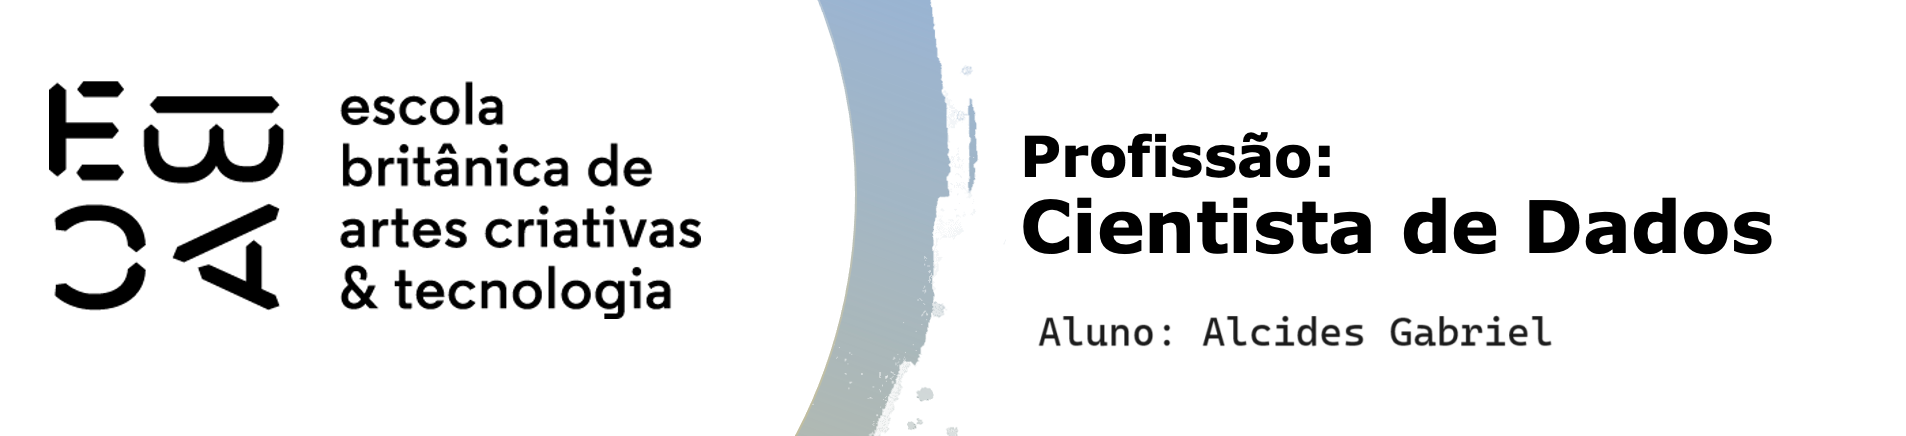

# índice
- [Tarefa](#0)
    - [Importação dos dados e bibliotecas](#0.0)
- [Análise Descritiva](#1)
    - [P.O.O. Análise](#1.0)
    - [Análise Inicial dos dados](#1.1)
    - [Conclusão da análise inicial](#1.2)
- [Aprendizado Não Supervisionado Utilizando KMeans](#2)
    - [Quantidade de Grupos](#2.0)
    - [Avaliação dos Grupos](#2.1)
    - [Avaliação dos Resultados](#2.2)

<a id=0></a>
# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

<a id=0.0></a>
### Importação dos dados e bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Dados/online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

<a id=1></a>
## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

<a id=1.0></a>
### PO Análise Inicial

In [5]:
class Analise():
    
    def __init__(self):
        self.data = df.copy()
    
    def aval_dataset(dt):
        print(f"O dataset apresenta \033[91m{df.shape[0]}\033[00m linhas e \033[91m{dt.shape[1]}\033[00m colunas")
        print(f"Um total de \033[91m{dt.isnull().sum().sum()}\033[00m de dadoz vazios")
        print(f"Um total de \033[91m{dt.duplicated().sum()}\033[00m dados duplicados")
        print(f"Sendo \033[91m{dt.select_dtypes(exclude=np.number).shape[1]}\033[00m dados categoricos e \033[91m{dt.select_dtypes(include=np.number).shape[1]}\033[00m dados numéricos")
        display(dt.select_dtypes(exclude=np.number).describe().T)
        df_ = dt.select_dtypes(include=np.number)
        contagem = dt.nunique()
        df_ = df_.describe().T
        df_['contagem'] = contagem
        display(df_)
        display(dt.head(3))
            
    def graf_disp_cat(dt,target):
        ## Inicial
        data = dt.copy()
        cat = data.select_dtypes(exclude=np.number).columns.tolist()
        num = data.select_dtypes(include=np.number).nunique()[data.select_dtypes(include=np.number).nunique()<50].index.tolist()
        dados = cat + num
        figura = plt.figure(figsize=(15,50))
        plt.subplots_adjust(top=0.95, # Distância do título para os gráficos.
                    wspace = 0.7,
                    hspace = 0.3)
        plt.suptitle('Gráfico de frequência das variáveis categóricas', fontsize=30)
        
        
        ## 
        desativar = False
        c = 0 
        dif = len(dados)
        tamanho = (4,3)
        for row in range(4):
            for col in range(3):
                pos = (row, col)
                if desativar:
                    break
                if c == dif-1:   
                    ax = plt.subplot2grid(tamanho, pos, colspan=2)
                    desativar = True
                else:
                    ax = plt.subplot2grid(tamanho, pos)
                ordem = data[dados[c]].value_counts().index
                fig = sns.countplot(data=data,y=dados[c], orient='h', order=ordem, hue=target)
                
                
                for p in fig.patches:

                    y = p.get_xy()[1]
                    x = p.get_width()
                    plt.annotate(x, xy=(x,y+.2), verticalalignment='center')
                    
                    
                plt.legend(loc='lower left', bbox_to_anchor=(1, 0))    
                plt.title(dados[c],fontsize=15)
                fig.spines['top'].set_visible(False)
                fig.spines['right'].set_visible(False),
                fig.set(xlabel='Frequência', ylabel='')
                c += 1
    
    def graf_disp_num(dt,target):   
        ## Inicial
        data = dt.copy()
        dados = data.select_dtypes(include=np.number).nunique()[data.select_dtypes(include=np.number).nunique()>50].index.tolist()
        dados.append(target)
        data = data[dados]
        sns.pairplot(data, hue=target)

<a id=1.1></a>
### Análise Inicial dos dados

In [6]:
Analise.aval_dataset(df)

O dataset apresenta 12330 linhas e 18 colunas
Um total de 0 de dadoz vazios
Um total de 125 dados duplicados
Sendo 4 dados categoricos e 14 dados numéricos


,count,unique,top,freq
Month,12330,10,May,3364
VisitorType,12330,3,Returning_Visitor,10551
Weekend,12330,2,False,9462
Revenue,12330,2,False,10422


,count,mean,std,min,25%,50%,75%,max,contagem
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000,27
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000,3335
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000,17
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000,1258
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000,311
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230,9551
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000,1872
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000,4777
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742,2704
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000,6


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


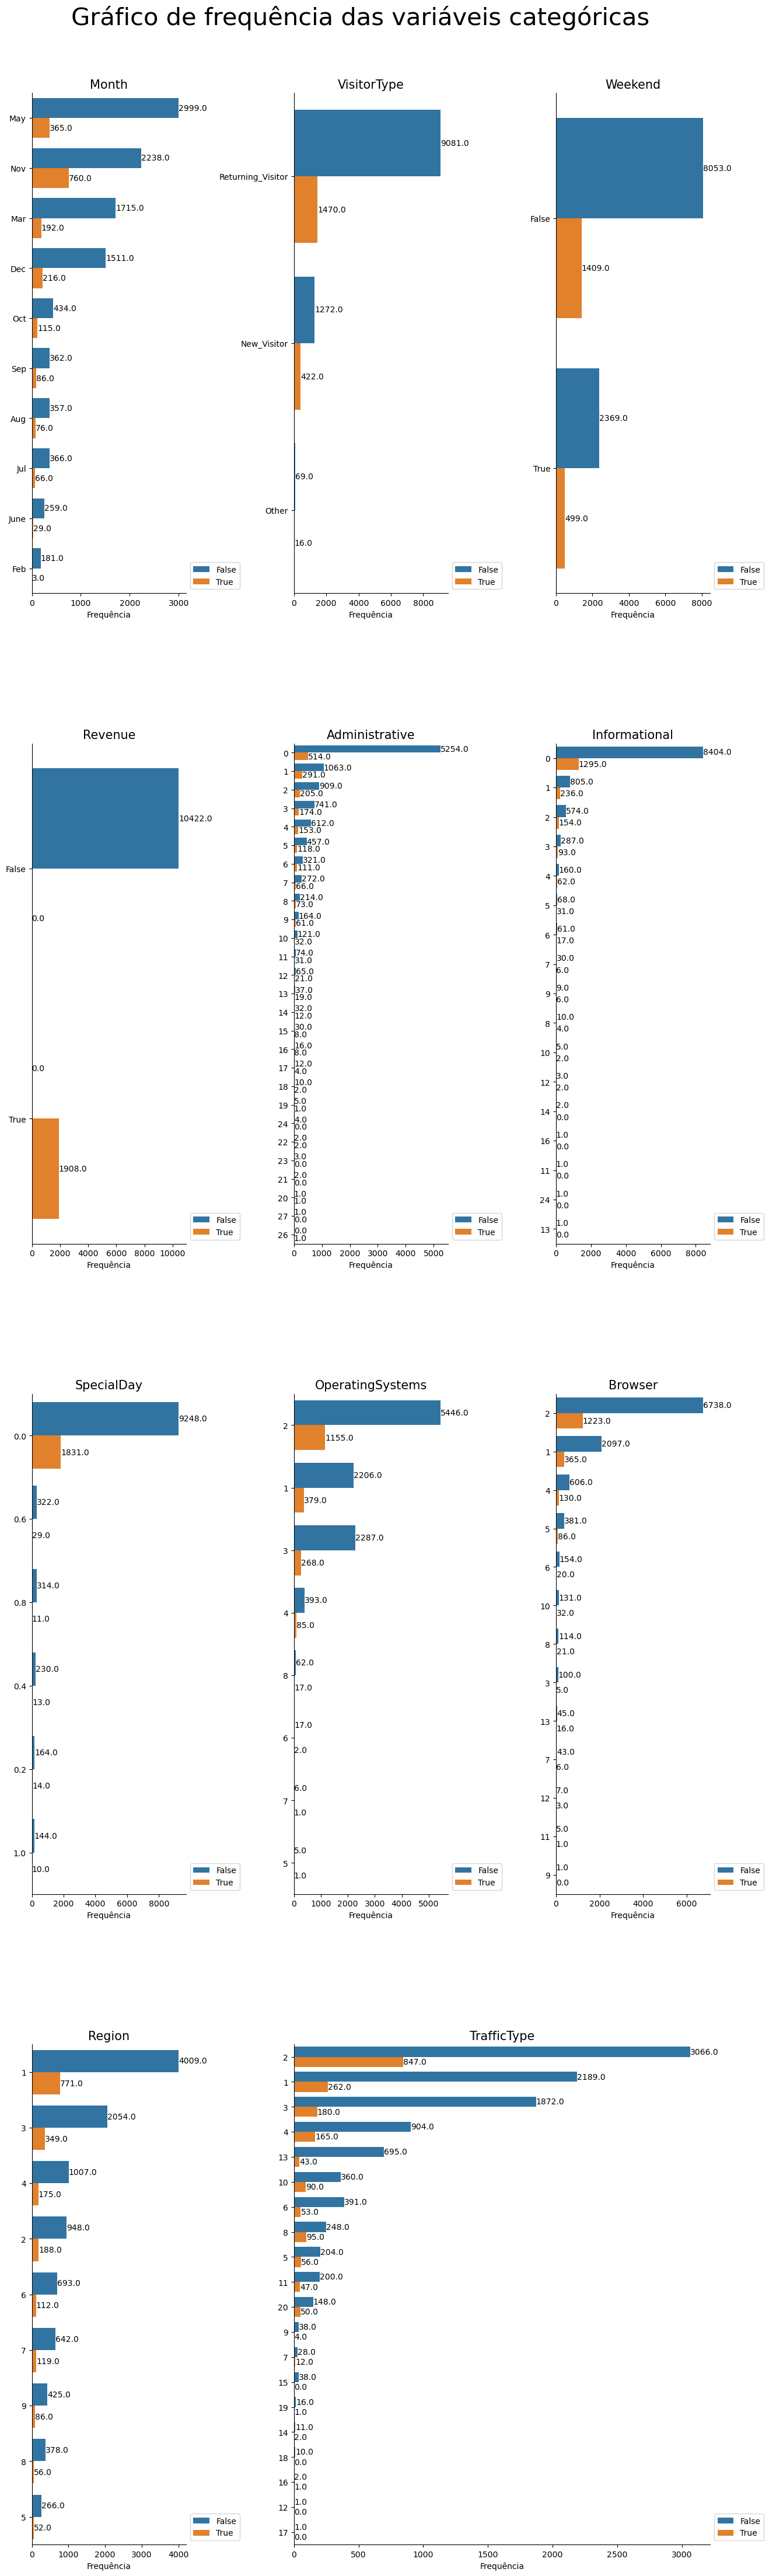

In [7]:
Analise.graf_disp_cat(df,'Revenue')

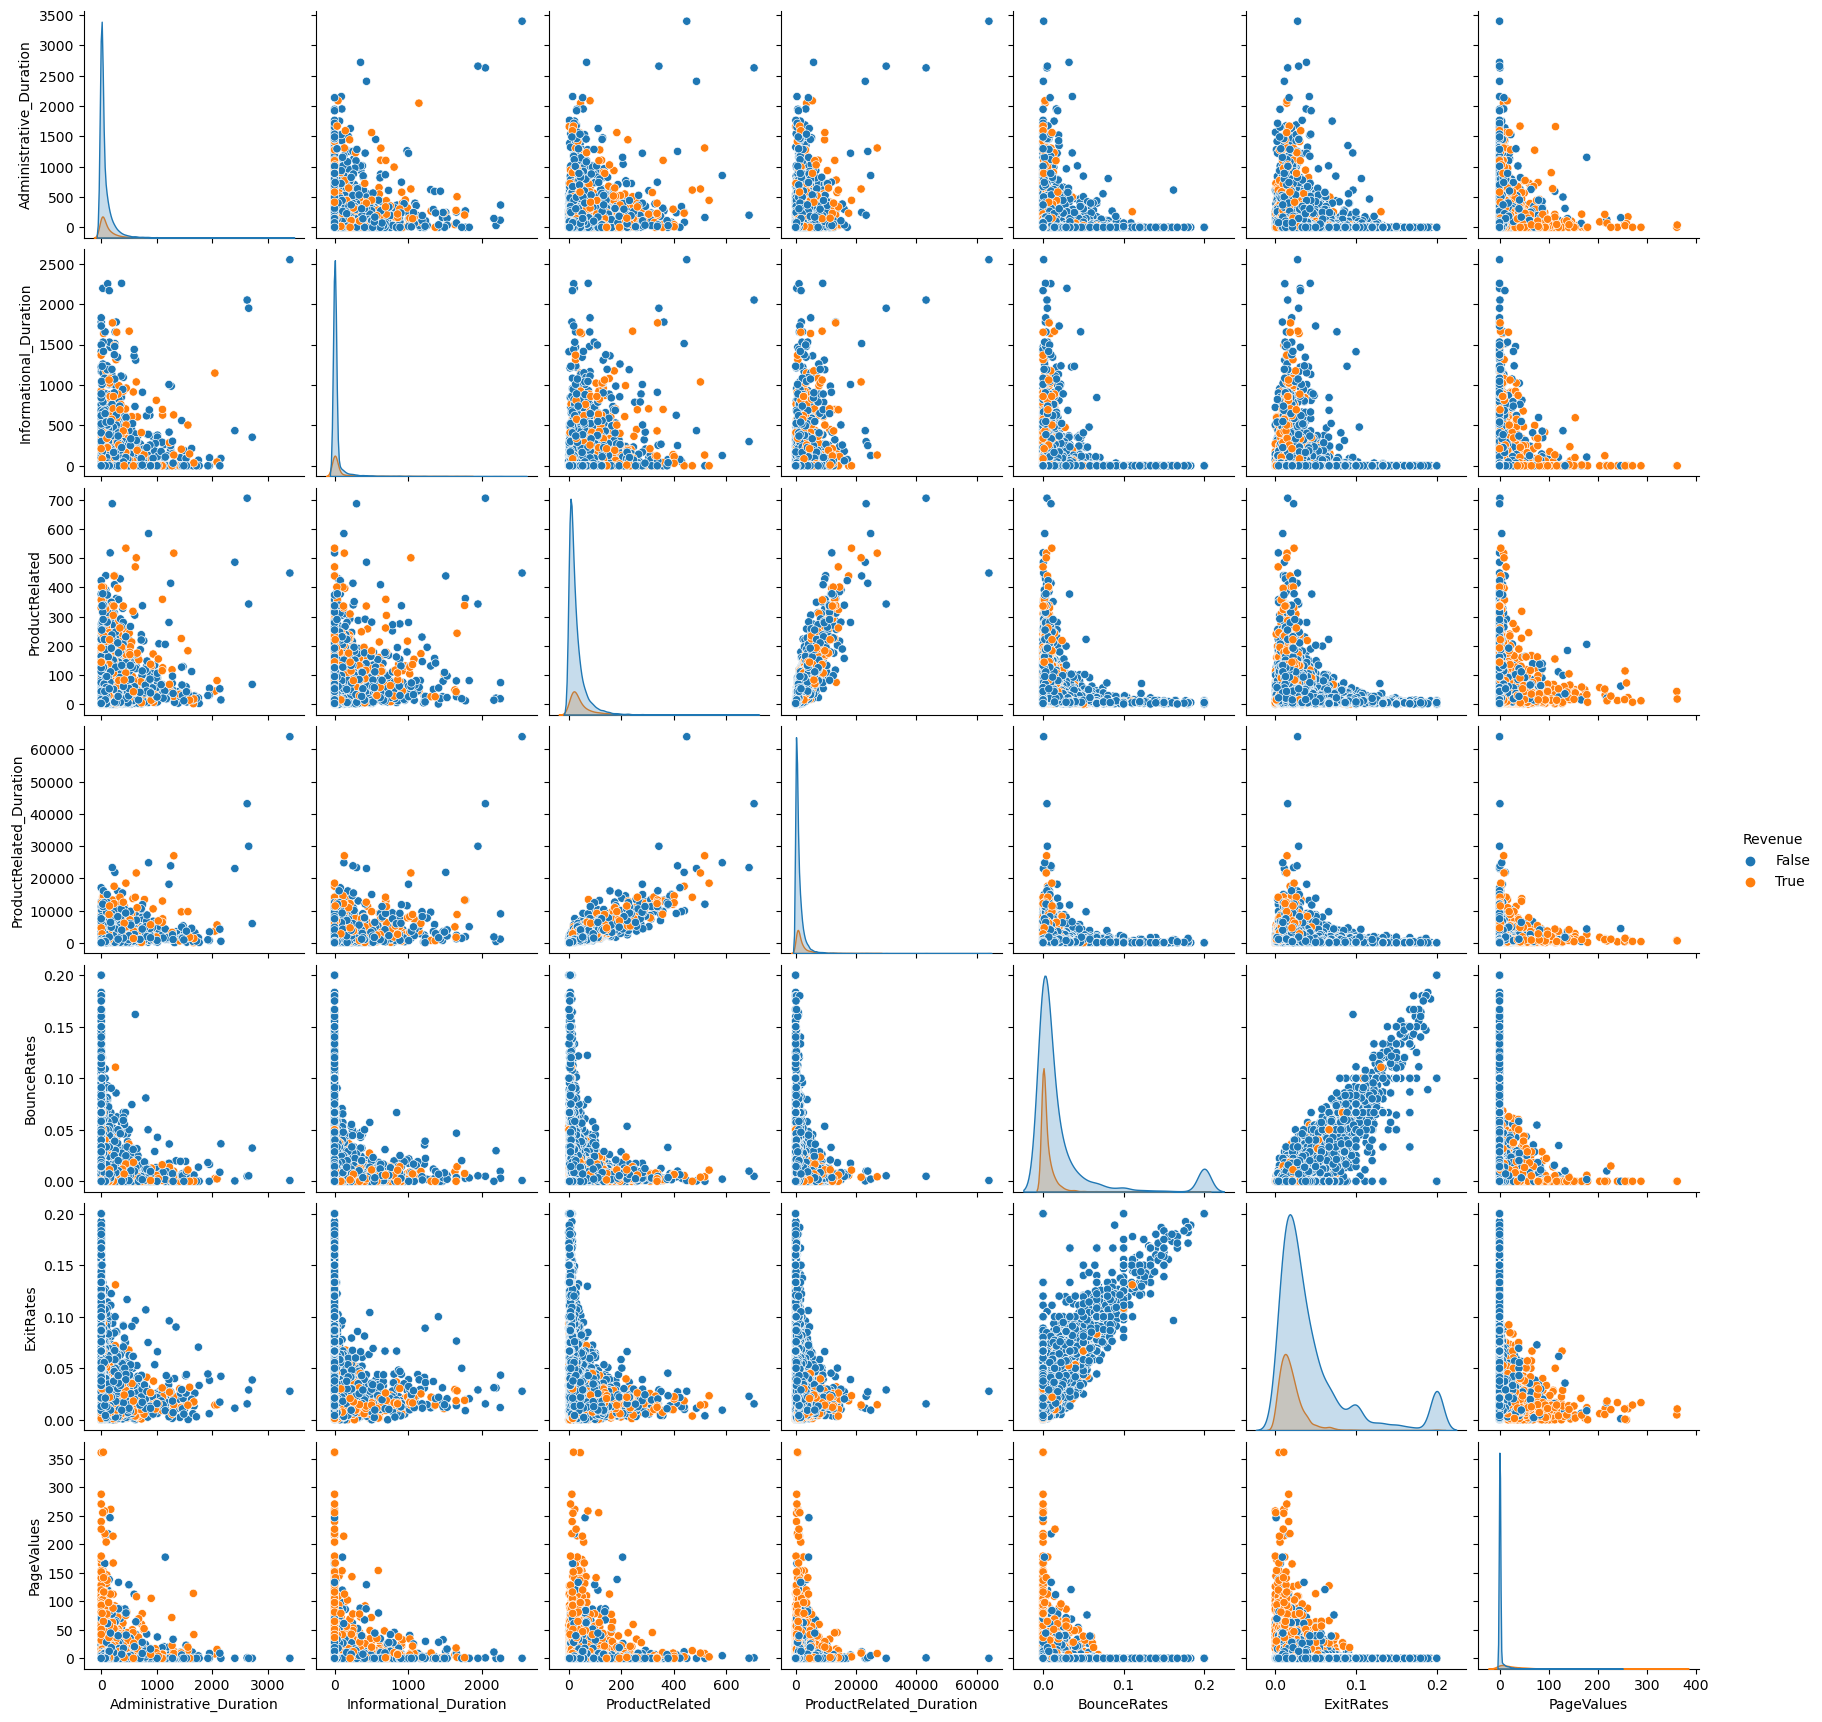

In [8]:
Analise.graf_disp_num(df, 'Revenue')

<a id=1.2></a>
### Conclusão da análise
- **Tratamento**
    - Dados não apresentam vazios
    - Dados apresentam dados repetidos
- **Dados Categóricos**
    - Diversos atributos apresentam pouca representatividade que podem até serem transformados, se necessário.
- **Dados Numéricos.**
    - Percebe-se que só alguns dados apresentam uma certa diferença em relação ao Revenue, algo que pode complicar para a análise não supervisionada.

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

<a id=2></a>
<a id=2.0></a>
## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

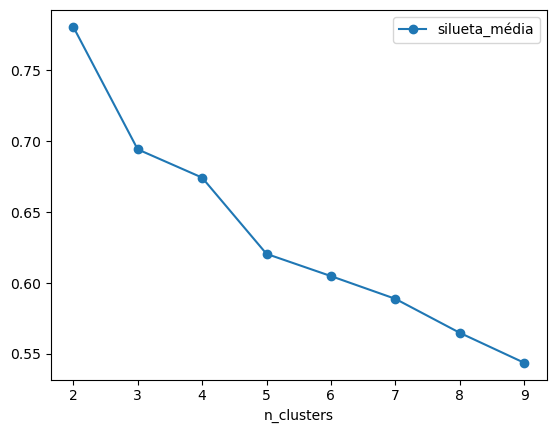

In [10]:
def avaliando_grupos(dt):
    data = dt.copy()
    for n in data.select_dtypes(exclude=np.number):
        data[n] = LabelEncoder().fit_transform(data[n])
        
    #classes = data.pop('Revenue')
    sulh = []
    for i in range(2,10,1):
        km = KMeans(n_clusters=i).fit(data)
        sulh.append(silhouette_score(data, km.labels_))
        
    df_sil = pd.DataFrame({'n_clusters':list(range(2, 10,1)), 'silueta_média':sulh})
    df_sil.plot.line(x='n_clusters', y='silueta_média',marker='o')
    
    
avaliando_grupos(df)        

<a id=2.1></a>
## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [11]:
def cluster(dt):
    data = dt.copy()
    d1 = dt.copy()
    for n in data.select_dtypes(exclude=np.number):
        data[n] = LabelEncoder().fit_transform(data[n])
    clas = data.pop('Revenue')
    
    data.iloc[:,:] = StandardScaler().fit_transform(data)
    
    km = KMeans(n_clusters=4, max_iter=1000, algorithm='auto')
    km.fit(data)
    d1['grupos'] = km.labels_
    return d1

In [12]:
df_cluster = cluster(df)

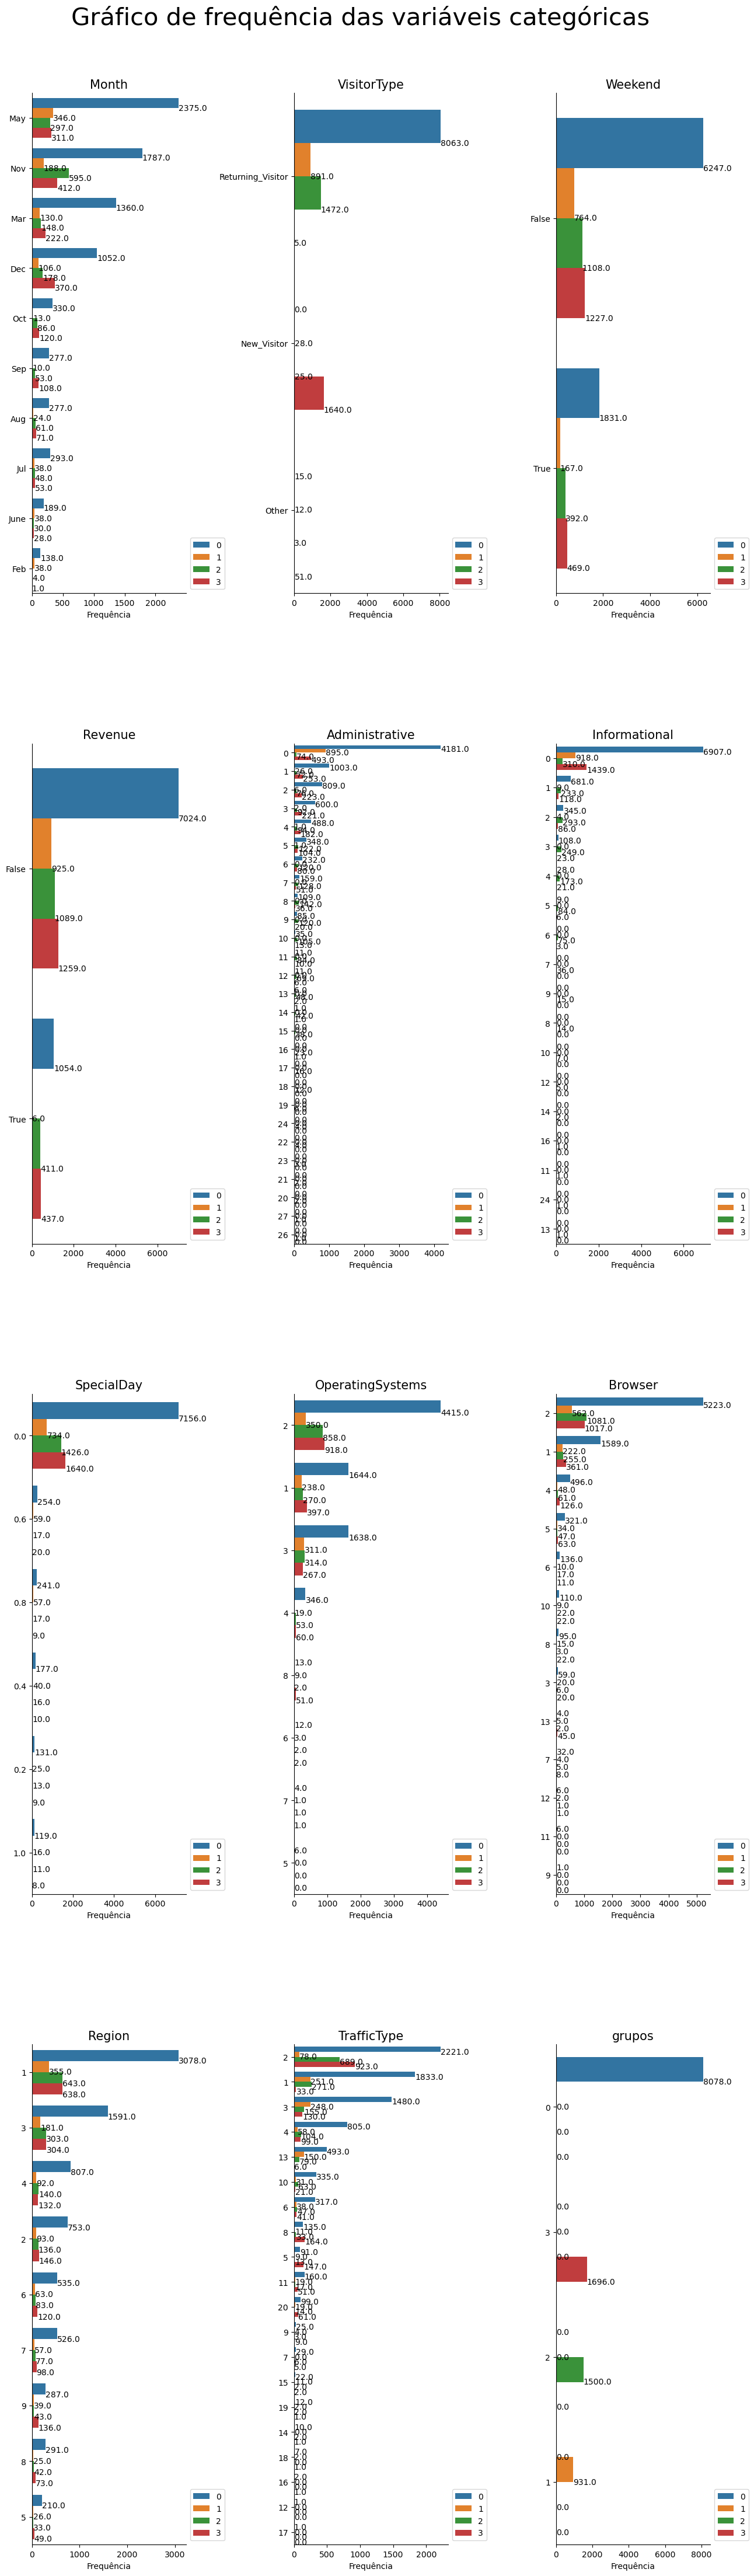

In [13]:
Analise.graf_disp_cat(df_cluster, 'grupos')

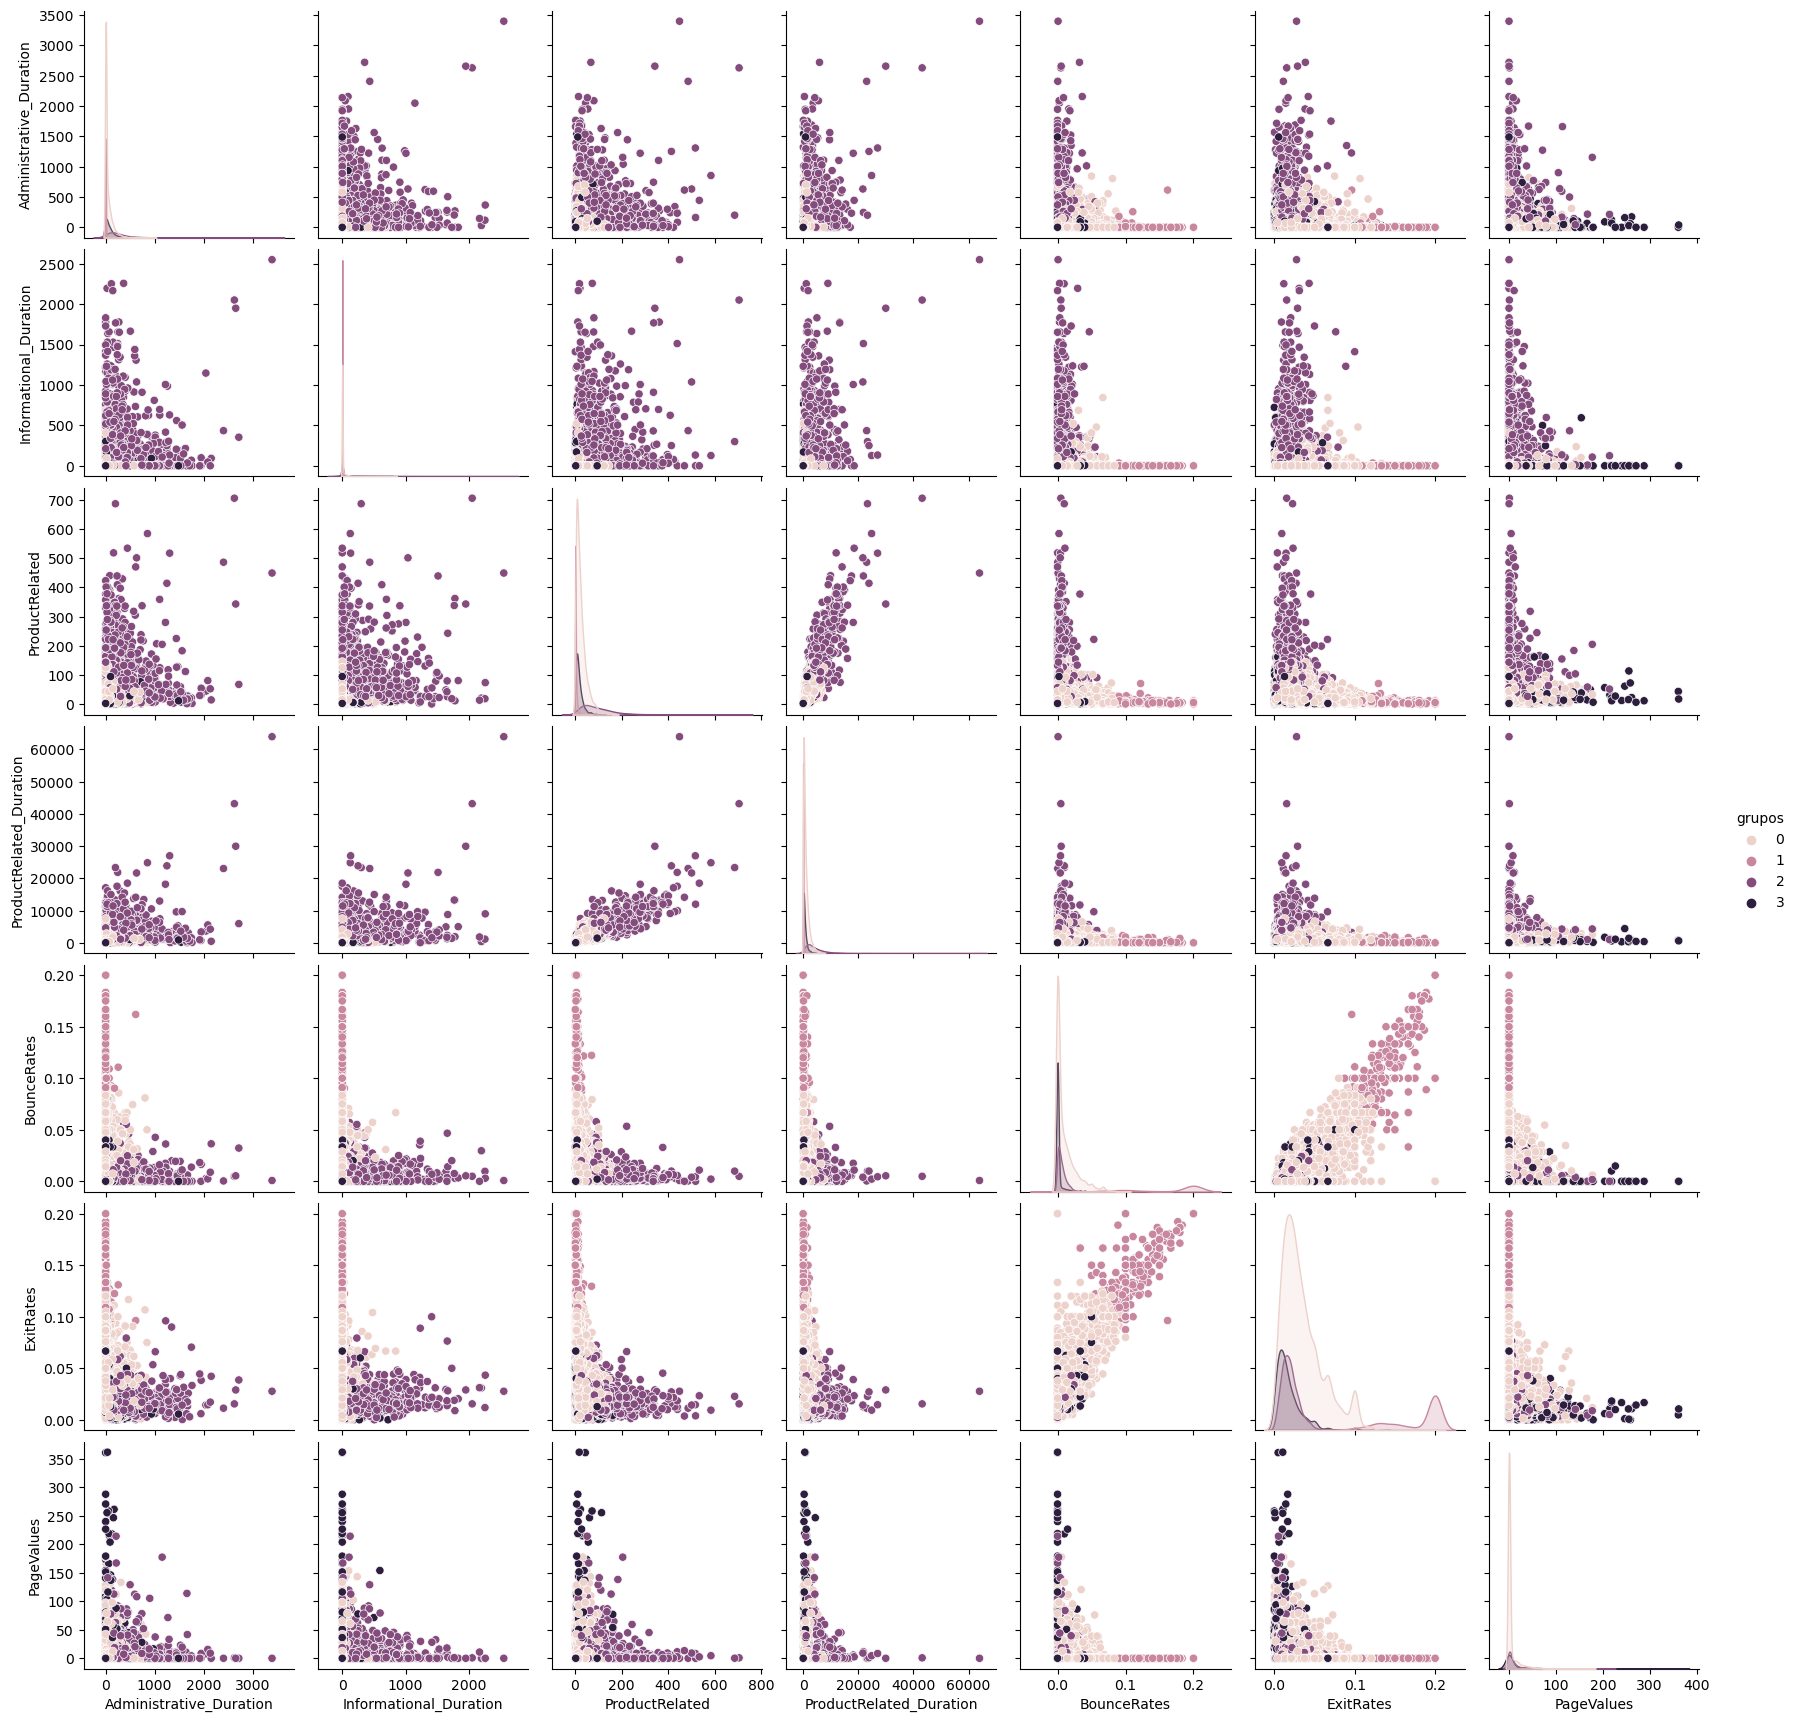

In [14]:
Analise.graf_disp_num(df_cluster, 'grupos')

<a id=2.2></a>
## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [15]:
df_cluster.select_dtypes(include=np.number).groupby('grupos').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
grupos,,,,,,,,,,,,,,
0,1.603120,47.554257,0.229265,8.588683,25.506932,940.433311,0.010566,0.034828,4.685524,0.069473,2.105224,2.339688,3.149047,3.984154
1,0.056928,1.670390,0.018260,0.104404,3.395274,65.271622,0.161496,0.177170,0.000000,0.126745,2.195489,2.314715,3.125671,5.228786
2,7.506667,312.653583,2.566000,220.986206,101.114000,4009.102724,0.006470,0.019768,9.331807,0.029200,2.116667,2.222000,2.872667,3.620000
3,2.525354,83.617141,0.289505,14.203289,17.830189,624.987405,0.001891,0.017775,12.244797,0.019458,2.182193,2.587854,3.436910,4.268868


In [16]:
df_cluster.groupby(['grupos','Revenue'])[df_cluster.select_dtypes(exclude=np.number).columns.tolist()].count()

Month  VisitorType  Weekend  Revenue
grupos Revenue                                      
0      False     7024         7024     7024     7024
       True      1054         1054     1054     1054
1      False      925          925      925      925
       True         6            6        6        6
2      False     1089         1089     1089     1089
       True       411          411      411      411
3      False     1259         1259     1259     1259
       True       437          437      437      437

In [17]:
for i in range(4):
    a = df_cluster.groupby(['grupos','Revenue'])[df_cluster.select_dtypes(exclude=np.number).columns.tolist()].count().T[i]
    resultado = (a[True] / a.sum(1)[0]) *100
    print(f'Para o grupo {i} a probabilidade de o cliente comprar é de {resultado[0]:.2f} %')

Para o grupo 0 a probabilidade de o cliente comprar é de 13.05 %
Para o grupo 1 a probabilidade de o cliente comprar é de 0.64 %
Para o grupo 2 a probabilidade de o cliente comprar é de 27.40 %
Para o grupo 3 a probabilidade de o cliente comprar é de 25.77 %


# Análise dos Grupos

- **Grupo 0**
    - Para o grupo 0 a probabilidade de o cliente comprar é de 13.04 %
- **Grupo 1**
    - Para o grupo 1 a probabilidade de o cliente comprar é de 0.64 %
- **Grupo 2**
    - Para o grupo 2 a probabilidade de o cliente comprar é de 27.40 %
- **Grupo 3**
    - Para o grupo 3 a probabilidade de o cliente comprar é de 25.77 %
    
- **Viabilidade dos grupos**
    - Analisando os dados acima, vemos que os clientes de grupo 3 e 4 podem ser unidos em um só, pela proximidade das probabilidades. Clientes do grupo 1 apresentam um resultado bem definido e clientes do grupo 0 podem ser mais estudados para ver em quais aspectos é possível crescer esses 13 %